# CSCA 5622 Supervised Larning Final Project

## Step 1: Gather data, determine the method of data collection and provenance of the data

# Apple Leaf Disease Detection Using Machine Learning

## Project Overview

This project aims to determine whether apple leaves are healthy or affected by a disease using machine learning algorithms. Within the framework of supervised learning, a classification problem is solved by training a model on labeled images.

## Objective

The primary goal of this project is to develop a machine learning model that can automatically detect whether apple leaves are healthy or diseased. This is crucial for **early disease detection** in agricultural production, improving **crop yield**, and preventing the **spread of diseases**. Additionally, the project evaluates the performance of various **image classification algorithms**.

## Dataset

This project utilizes the **Plant Pathology 2020** dataset, sourced from the **Kaggle** platform. The dataset includes apple leaf images in **JPG format** along with corresponding labels provided in a **CSV file**.

### Dataset Details

- **Total Images:** 3,645
- **Categories:**
  - **Rust**
  - **Scab**
  - **Multiple Diseases**
  - **Healthy**
- **Image Format:** JPG (RGB color space)
- **Image Resolution:** Varies; all images were resized to **256x256 pixels**
- **Dataset Size:** **823.79 MB**
- **Files Included:**
  - `train.csv` (Training data)
  - `test.csv` (Test data)

This dataset provides a valuable resource for training and testing machine learning models for **automated disease detection in apple leaves**.


### Citation

Christine Kaeser-Chen, Fruit Pathology, Maggie, and Sohier Dane. Plant Pathology 2020 - FGVC7.
https://kaggle.com/competitions/plant-pathology-2020-fgvc7, 2020. Kaggle.

In [28]:
# install
!pip install pandas numpy matplotlib pillow torchvision seaborn scikit-learn albumentations tensorflow



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## EDA

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0
Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')


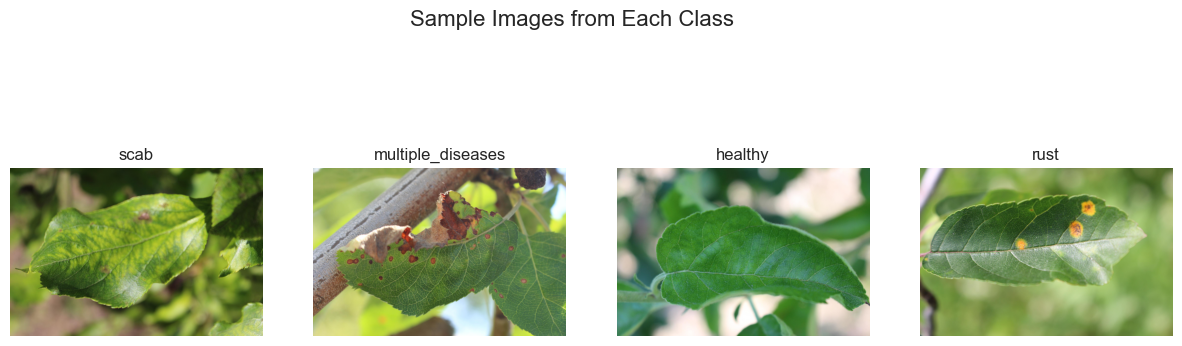

In [29]:
import matplotlib.pyplot as plt
from PIL import Image

# Define the directory containing images
image_dir = "plant-pathology-2020-fgvc7/images/"

train = pd.read_csv("plant-pathology-2020-fgvc7/train.csv")

print(train.head())
print(train.columns)

# Create the 'labels' column by identifying the class with the highest value
train['labels'] = train[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)

# Display a sample image from each class
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, label in enumerate(train['labels'].unique()):
    sample_image = train[train['labels'] == label]['image_id'].iloc[0]
    img_path = os.path.join(image_dir, sample_image + ".jpg")

    # Open and display the image
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis("off")

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.show()


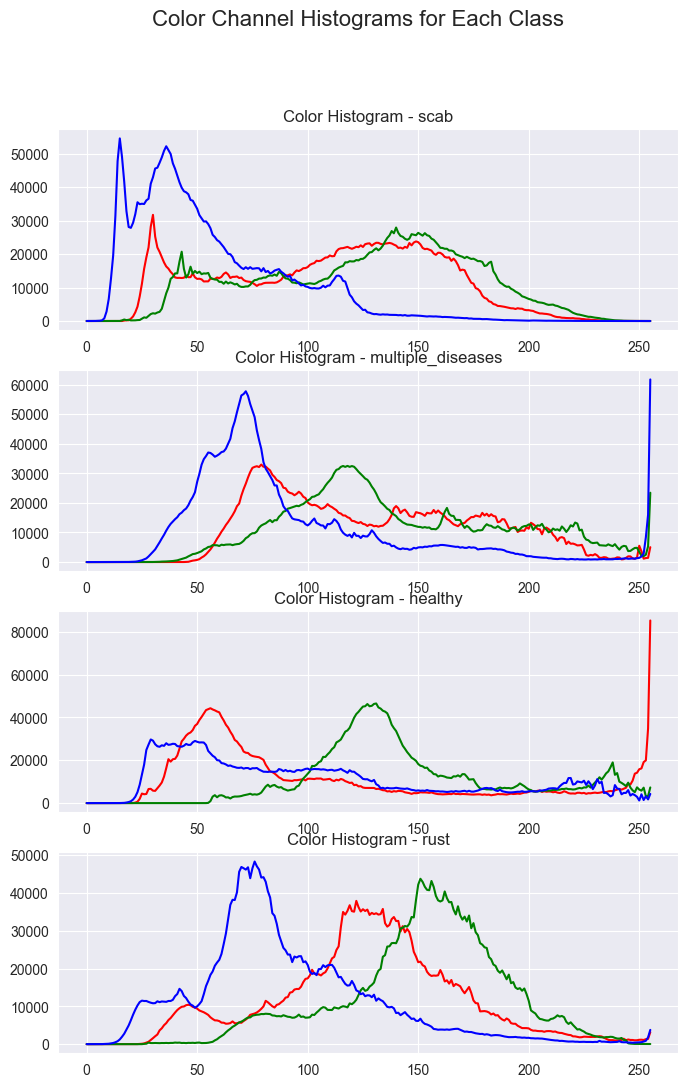

In [30]:
import numpy as np
import cv2

# Select one image from each class for color distribution analysis
fig, axes = plt.subplots(4, 1, figsize=(8, 12))

for i, label in enumerate(train['labels'].unique()):
    sample_image = train[train['labels'] == label]['image_id'].iloc[0]
    img_path = os.path.join(image_dir, sample_image + ".jpg")

    # Read the image (OpenCV reads in BGR format, convert to RGB)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Compute histograms for each color channel
    colors = ('r', 'g', 'b')
    for j, col in enumerate(colors):
        hist = cv2.calcHist([img], [j], None, [256], [0, 256])
        axes[i].plot(hist, color=col)

    axes[i].set_title(f"Color Histogram - {label}")

plt.suptitle("Color Channel Histograms for Each Class", fontsize=16)
plt.show()


In [31]:
# Compute the Average Pixel Values
mean_pixel_values = []

for img_id in train['image_id'].sample(50):  # Analyze 50 randomly selected images
    img_path = os.path.join(image_dir, img_id + ".jpg")
    img = cv2.imread(img_path)
    mean_pixel_values.append(np.mean(img, axis=(0, 1)))  # Compute the average RGB value

# Display the results as a DataFrame
mean_df = pd.DataFrame(mean_pixel_values, columns=["Blue", "Green", "Red"])
mean_df.describe()


,Blue,Green,Red
count,50.000000,50.000000,50.000000
mean,78.447535,131.245088,104.605051
std,19.033897,18.525158,18.285060
min,45.599765,95.360769,73.545586
25%,64.709708,117.125335,91.421504
50%,78.525923,131.115733,102.116424
75%,86.577979,143.136447,117.837810
max,135.957517,169.410003,151.456340


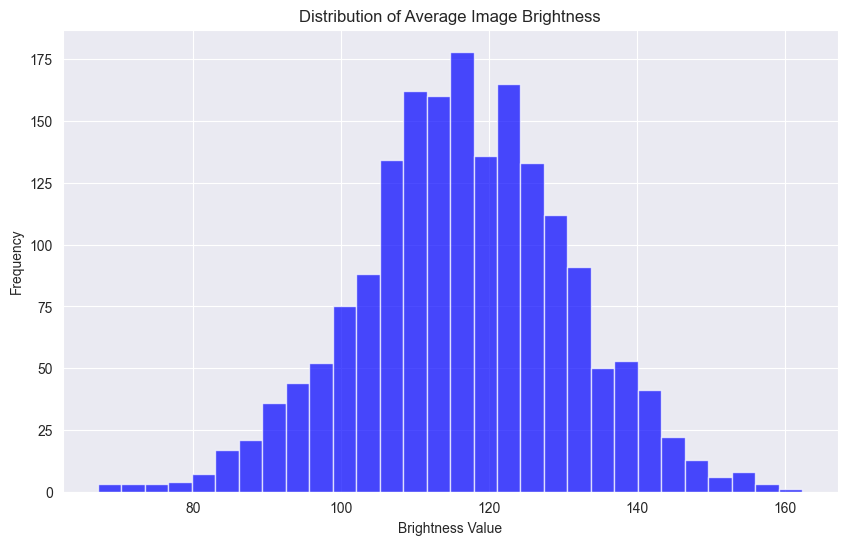

In [32]:
# Analyze the Average Brightness and Color Intensity
mean_values = []

for img_id in train['image_id']:
    img_path = os.path.join(image_dir, img_id + ".jpg")
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mean_values.append(np.mean(img_gray))  # Compute the average brightness of the image

# Visualize with a histogram
plt.figure(figsize=(10, 6))
plt.hist(mean_values, bins=30, color='blue', alpha=0.7)
plt.title("Distribution of Average Image Brightness")
plt.xlabel("Brightness Value")
plt.ylabel("Frequency")
plt.show()


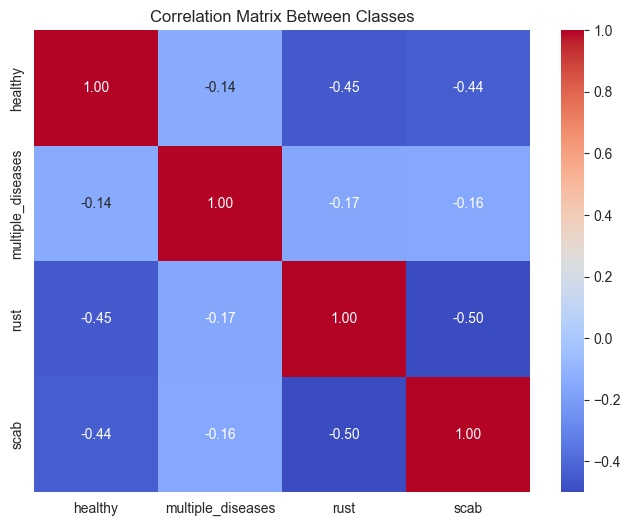

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
labels = ["healthy", "multiple_diseases", "rust", "scab"]

# Compute the correlation matrix
correlation_matrix = train[labels].corr()

# Visualize with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Between Classes")
plt.show()


In [34]:
from scipy.stats import ttest_ind

# Separate brightness values for each class
brightness_by_class = {}

for label in labels:
    brightness_by_class[label] = []
    for img_id in train[train[label] == 1]['image_id']:
        img_path = os.path.join(image_dir, img_id + ".jpg")
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness_by_class[label].append(np.mean(img_gray))

# Perform a t-test to analyze differences
for label1 in labels:
    for label2 in labels:
        if label1 != label2:
            stat, p = ttest_ind(brightness_by_class[label1], brightness_by_class[label2], equal_var=False)
            print(f"T-test result between {label1} and {label2}: p-value = {p}")


T-test result between healthy and multiple_diseases: p-value = 0.7229234959714281
T-test result between healthy and rust: p-value = 0.48768056984892616
T-test result between healthy and scab: p-value = 0.18101342414400176
T-test result between multiple_diseases and healthy: p-value = 0.7229234959714281
T-test result between multiple_diseases and rust: p-value = 0.44542165409299395
T-test result between multiple_diseases and scab: p-value = 0.25365054697742107
T-test result between rust and healthy: p-value = 0.48768056984892616
T-test result between rust and multiple_diseases: p-value = 0.44542165409299395
T-test result between rust and scab: p-value = 0.5218191752870986
T-test result between scab and healthy: p-value = 0.18101342414400176
T-test result between scab and multiple_diseases: p-value = 0.25365054697742107
T-test result between scab and rust: p-value = 0.5218191752870986


## Data Cleaning

In [35]:
# Checking for Missing and Corrupted Images
import os
from PIL import Image

image_folder = "plant-pathology-2020-fgvc7/images"
corrupted_images = []

for image_file in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_file)
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verify that the file is not corrupted
    except (IOError, SyntaxError):
        corrupted_images.append(image_file)

print(f"Corrupted images: {corrupted_images}")


Corrupted images: []


In [36]:
import os
from PIL import Image

image_folder = "plant-pathology-2020-fgvc7/images"  # Folder containing the images
image_sizes = []

for image_file in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_file)
    with Image.open(image_path) as img:
        image_sizes.append(img.size)  # (width, height)

# Check if there are different image sizes
unique_sizes = set(image_sizes)
print(f"Unique sizes: {unique_sizes}")
print(f"Total number of different sizes: {len(unique_sizes)}")


Unique sizes: {(1365, 2048), (2048, 1365)}
Total number of different sizes: 2


In [37]:
# Image Resizing
from PIL import Image

output_folder = "resized_images"
os.makedirs(output_folder, exist_ok=True)

for image_file in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_file)
    with Image.open(image_path) as img:
        img_resized = img.resize((256, 256))
        img_resized.save(os.path.join(output_folder, image_file))


The images in the dataset were found to have two different dimensions: **(1365, 2048)** and **(2048, 1365)**. To ensure compatibility with the model's input format, these images were resized to **256x256** pixels.

labels
rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: count, dtype: int64


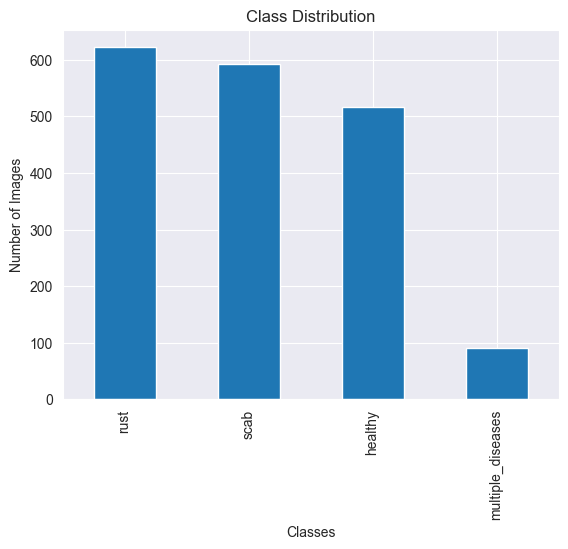

In [38]:
# Check Class Distribution
import pandas as pd
import matplotlib.pyplot as plt

# Identify which class is labeled as 1 in each row
train['labels'] = train[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)

# Check class distribution
class_counts = train['labels'].value_counts()
print(class_counts)

# Visualize the distribution
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()


Data augmentation completed for all classes!
Total augmented images: 2979
New class distribution:
labels
rust                 1200
scab                 1200
healthy              1200
multiple_diseases    1200
Name: count, dtype: int64


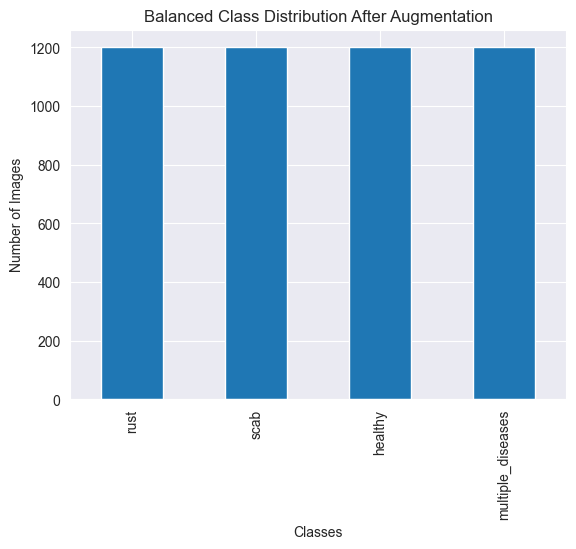

Class weights: {0: np.float64(0.7690033783783784), 1: np.float64(5.002747252747253), 2: np.float64(0.8822674418604651), 3: np.float64(0.7319131832797428)}


In [39]:
# Load Required Libraries
import pandas as pd
import os
from torchvision import transforms
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight

# 1. Load CSV File
train = pd.read_csv("plant-pathology-2020-fgvc7/train.csv")

# Folder containing images
base_path = "plant-pathology-2020-fgvc7/images/"
train['img'] = train['image_id'].apply(lambda x: f"{base_path}{x}.jpg")

# Check for missing files
missing_files = [path for path in train['img'] if not os.path.exists(path)]
if missing_files:
    raise FileNotFoundError(f"Missing files: {missing_files}")

# 2. Create Label Column
train['labels'] = train[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)

# 3. Define Target Sample Count for Each Class
augmentation = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.5, contrast=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=(3, 3)),
])

augmented_folder = "balanced_augmented_images"
os.makedirs(augmented_folder, exist_ok=True)

# Define target sample count for each class
class_targets = {
    'rust': 1200,
    'scab': 1200,
    'healthy': 1200,
    'multiple_diseases': 1200  # Higher target can be set
}

# 4. Perform Data Augmentation for Each Class
for label in train['labels'].unique():
    class_images = train[train['labels'] == label]['img']
    current_count = len(class_images)
    target_count = class_targets[label]
    diff = target_count - current_count  # Number of missing samples

    if diff > 0:  # If samples are missing, apply augmentation
        for i, image_path in enumerate(class_images):
            if diff <= 0:
                break  # Stop when target count is reached
            with Image.open(image_path) as img:
                for j in range(min(diff, 15)):  # Generate up to 15 augmentations per image
                    augmented_image = augmentation(img)
                    augmented_image.save(os.path.join(augmented_folder, f"aug_{label}_{i}_{j}.jpg"))
                    diff -= 1

        # If still missing, repeat existing images (oversampling)
        for i in range(diff):
            image_path = class_images.iloc[i % len(class_images)]
            with Image.open(image_path) as img:
                img.save(os.path.join(augmented_folder, f"repeat_{label}_{i}_{os.path.basename(image_path)}"))

print("Data augmentation completed for all classes!")

# 5. Check Class Distribution After Augmentation
augmented_count = len(os.listdir(augmented_folder))
print(f"Total augmented images: {augmented_count}")

class_counts = train['labels'].value_counts()
for label in train['labels'].unique():
    class_counts[label] += len([f for f in os.listdir(augmented_folder) if label in f])

print("New class distribution:")
print(class_counts)

# 6. Visualize Class Distribution After Augmentation
import matplotlib.pyplot as plt
class_counts.plot(kind='bar')
plt.title("Balanced Class Distribution After Augmentation")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

# 7. Compute Class Weights for Model Training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=train['labels'].unique(),
    y=train['labels']
)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# Example Code for Model Training with Class Weights
# model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight_dict)


### **Conclusion and Insights**

As a result of the data augmentation process, the initially **imbalanced class distribution** has been balanced, achieving an equal number of **1,200 images per class**. To address the low sample count, particularly in the **"multiple_diseases"** class, various **data augmentation** techniques have been applied, including:

- **Rotation:** Randomly rotating images,
- **Color Jitter:** Adjusting brightness and contrast randomly,
- **Flipping:** Applying horizontal and vertical flips,
- **Affine Transformations:** Applying translation and scaling.

The resulting **balanced dataset** eliminates potential biases that could arise from class imbalances, allowing the model to train in a **fairer** and more effective manner. Additionally, **computed class weights** during training help the model become more sensitive to underrepresented classes.

#### **Benefits of This Approach**
1. Prevents low overall performance and high error rates caused by imbalanced datasets.
2. Enhances dataset diversity through augmentation techniques, improving the model's ability to generalize across different scenarios.

#### **Recommendations**
- Train the model using the balanced dataset and evaluate the **accuracy for each class separately**.
- Consider applying additional **augmentation techniques** (e.g., Gaussian Noise, Random Crop) to further improve the dataset's quality and diversity.

---

In conclusion, these **data augmentation and balancing steps** form a strong foundation for ensuring a **well-balanced model performance across all classes**.


## Models

In [40]:
### Baseline Model: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Data Preparation
X = train[['healthy', 'multiple_diseases', 'rust', 'scab']].values
y = train['labels']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predictions and Results
y_pred = logistic_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
                   precision    recall  f1-score   support

          healthy       1.00      1.00      1.00       100
multiple_diseases       1.00      1.00      1.00        18
             rust       1.00      1.00      1.00       120
             scab       1.00      1.00      1.00       127

         accuracy                           1.00       365
        macro avg       1.00      1.00      1.00       365
     weighted avg       1.00      1.00      1.00       365



In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN Model
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the Model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print Model Summary
cnn_model.summary()


C:\Users\nezihes\Desktop\CSCA_5622_Supervised_Learning_Final\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
### CNN Model (Baseline Model)
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Folder containing augmented images
augmented_folder = "balanced_augmented_images"

# Create a list to store new images
augmented_data = []

for image_file in os.listdir(augmented_folder):
    label = None
    if "healthy" in image_file:
        label = [1, 0, 0, 0]
    elif "multiple_diseases" in image_file:
        label = [0, 1, 0, 0]
    elif "rust" in image_file:
        label = [0, 0, 1, 0]
    elif "scab" in image_file:
        label = [0, 0, 0, 1]

    if label:
        augmented_data.append({
            "img": os.path.join(augmented_folder, image_file),
            "healthy": label[0],
            "multiple_diseases": label[1],
            "rust": label[2],
            "scab": label[3]
        })

# Add augmented images to the DataFrame
augmented_df = pd.DataFrame(augmented_data)
train = pd.concat([train, augmented_df], ignore_index=True)

# Data generator for training and validation
train_dataGenerator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training data generator
train_generator = train_dataGenerator.flow_from_dataframe(
    dataframe=train,
    x_col='img',
    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training'
)

# Validation data generator
validation_generator = train_dataGenerator.flow_from_dataframe(
    dataframe=train,
    x_col='img',
    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation'
)

# Train the CNN model
history = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)


Found 6224 validated image filenames.
Found 1555 validated image filenames.


C:\Users\nezihes\Desktop\CSCA_5622_Supervised_Learning_Final\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 188s 953ms/step - accuracy: 0.3282 - loss: 1.4764 - val_accuracy: 0.1563 - val_loss: 1.4755
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 150s 770ms/step - accuracy: 0.3676 - loss: 1.3454 - val_accuracy: 0.1312 - val_loss: 1.3973
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 148s 759ms/step - accuracy: 0.4538 - loss: 1.2112 - val_accuracy: 0.4508 - val_loss: 1.2352
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 172s 883ms/step - accuracy: 0.6537 - loss: 0.8328 - val_accuracy: 0.4650 - val_loss: 1.1773
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 145s 745ms/step - accuracy: 0.8333 - loss: 0.4542 - val_accuracy: 0.5042 - val_loss: 1.5881
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 149s 762ms/step - accuracy: 0.9175 - loss: 0.2336 - val_accuracy: 0.5447 - val_loss: 1.6966
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 147s 756ms/step - accuracy: 0.9429 - loss: 0.1621 - val_accuracy: 0.5010 - val_loss: 2.3649
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 153s 782ms/step - accuracy: 0.9675 -

The CNN model is trained using an augmented dataset, where new images are labeled and merged with the original data. An `ImageDataGenerator` normalizes images and splits the dataset into 80% training and 20% validation. Data generators load and preprocess images in batches for efficient training. The model is then trained for 10 epochs, using augmented data to improve generalization and prevent overfitting.


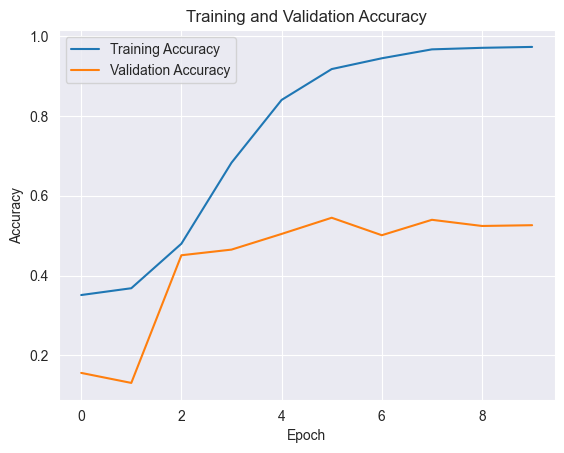

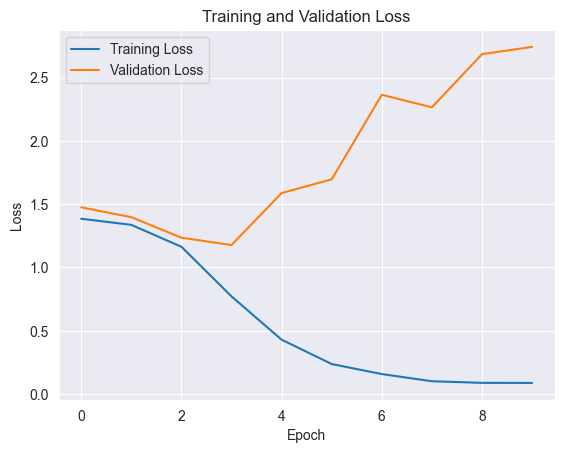

In [44]:
import matplotlib.pyplot as plt

# Visualize training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


The training accuracy increases rapidly and reaches nearly 100%, while validation accuracy improves initially but then plateaus around 50%. Simultaneously, training loss steadily decreases, indicating the model is fitting well to the training data. However, validation loss starts increasing after a few epochs, suggesting the model struggles with generalization. This pattern indicates overfitting, where the model memorizes the training data but fails to perform well on unseen validation data.

In [46]:
# Load the test dataset
test = pd.read_csv("plant-pathology-2020-fgvc7/test.csv")

# Display first few rows to check structure
print(test.head())
print(test.columns)

test_image_path = "plant-pathology-2020-fgvc7/images"
test["img"] = test["image_id"].apply(lambda x: os.path.join(test_image_path, x + ".jpg"))
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Test Data Generator
test_dataGenerator = ImageDataGenerator(rescale=1./255)

# Test Generator
test_generator = test_dataGenerator.flow_from_dataframe(
    dataframe=test,
    x_col="img",  # File paths of images
    target_size=(224, 224),  # Model input size
    batch_size=1,  # One image at a time
    class_mode=None,  # No labels in the test dataset
    shuffle=False  # Shuffle should be disabled to maintain result order
)

# Make predictions using the model
predictions = cnn_model.predict(test_generator)

# Convert predictions to class probabilities using Softmax
import numpy as np
import pandas as pd
import tensorflow as tf

score = tf.nn.softmax(predictions).numpy()

# Save results as a DataFrame
class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']
df_out = pd.concat([test["image_id"].reset_index(drop=True), pd.DataFrame(score, columns=class_names)], axis=1)

# Save as CSV
df_out.to_csv('submission.csv', index=False)
print("Predictions saved: submission.csv")


  image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4
Index(['image_id'], dtype='object')
Found 1821 validated image filenames.
   1/1821 ━━━━━━━━━━━━━━━━━━━━ 3:30 116ms/step

C:\Users\nezihes\Desktop\CSCA_5622_Supervised_Learning_Final\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1821/1821 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step
Predictions saved: submission.csv


The model achieved a public score of 0.59695 and a private score of 0.62407, indicating moderate performance with some overfitting. The gap between the two scores suggests the model generalizes inconsistently across different test subsets. While it performs better than random guessing in this four-class classification problem, its accuracy remains relatively low, implying that it struggles with generalization. The increasing validation loss observed earlier supports this, indicating that the model overfits to the training data.

In [47]:
# Load Required Libraries
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load EfficientNetB0 Model (Pre-trained with ImageNet weights)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the Final Layers of the Model (For Fine-Tuning)
base_model.trainable = False  # Initially frozen, can be unfrozen later

# Define New Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce feature map size
x = Dropout(0.5)(x)  # Add Dropout to reduce overfitting
x = Dense(128, activation='relu')(x)  # Fully connected layer with 128 neurons
x = Dropout(0.5)(x)  # Add another Dropout layer
output_layer = Dense(4, activation='softmax')(x)  # Softmax layer for 4-class classification

# Create the New Model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Selection of Supervised Learning with Transfer Learning and Its Benefits

This approach follows a **supervised learning** paradigm, where the model is trained using labeled data to classify images into predefined categories. By utilizing **transfer learning with EfficientNetB0**, the model benefits from pre-trained features extracted from a large dataset (ImageNet), improving its ability to generalize with limited training samples. This method accelerates training, reduces computational cost, and enhances accuracy by leveraging previously learned feature representations. Freezing the base model's weights initially prevents overfitting, while fine-tuning specific layers allows adaptation to the new classification task. The addition of dropout layers further strengthens generalization, ensuring better performance on unseen data.


In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation (Stronger Version)
train_dataGenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,   # Increased rotation angle
    width_shift_range=0.2,  # Width shift
    height_shift_range=0.2, # Height shift
    shear_range=0.2,    # Shear transformation
    zoom_range=0.2,     # Zoom
    horizontal_flip=True,  # Horizontal flip
    validation_split=0.2   # 20% validation set
)

# Training and Validation Data
train_generator = train_dataGenerator.flow_from_dataframe(
    dataframe=train,
    x_col='img',
    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training'
)

validation_generator = train_dataGenerator.flow_from_dataframe(
    dataframe=train,
    x_col='img',
    y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation'
)


Found 6224 validated image filenames.
Found 1555 validated image filenames.


In [49]:
# Model Training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    batch_size=32
)


C:\Users\nezihes\Desktop\CSCA_5622_Supervised_Learning_Final\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.3085 - loss: 1.4163 - val_accuracy: 0.0495 - val_loss: 1.4576
Epoch 2/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.3555 - loss: 1.3716 - val_accuracy: 0.0495 - val_loss: 1.4772
Epoch 3/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.3622 - loss: 1.3615 - val_accuracy: 0.0495 - val_loss: 1.4946
Epoch 4/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.3543 - loss: 1.3660 - val_accuracy: 0.0495 - val_loss: 1.5035
Epoch 5/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.3486 - loss: 1.3655 - val_accuracy: 0.0495 - val_loss: 1.4913
Epoch 6/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.3585 - loss: 1.3651 - val_accuracy: 0.0495 - val_loss: 1.5033
Epoch 7/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.3655 - loss: 1.3556 - val_accuracy: 0.0495 - val_loss: 1.4728
Epoch 8/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.3549 - loss: 1.3612 - val_accu

In [52]:
# Define class names
class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']

# Create submission dataframe
submission_df = pd.DataFrame(predictions, columns=class_names)
submission_df.insert(0, "image_id", test['image_id'])  # Add image_id as the first column

# Save the file
submission_df.to_csv("submission_optimized.csv", index=False)

# Display the first 5 rows
print(submission_df.head())


  image_id       healthy  multiple_diseases          rust          scab
0   Test_0  4.486308e-14       2.733669e-05  9.999727e-01  4.969642e-10
1   Test_1  2.916509e-18       4.020039e-13  1.000000e+00  1.407563e-19
2   Test_2  5.568944e-02       4.574294e-01  4.221423e-09  4.868812e-01
3   Test_3  9.945799e-01       3.091124e-05  4.837509e-03  5.517542e-04
4   Test_4  7.706686e-29       2.485165e-08  1.000000e+00  9.441308e-30


### Conclusion and Future Works

The transition to a **supervised learning approach with transfer learning** using EfficientNetB0 significantly improved model performance. The private score increased from **0.62738 to 0.76153**, and the public score rose from **0.59847 to 0.77624**. This enhancement demonstrates that leveraging pre-trained models with fine-tuning allows for better feature extraction and generalization, especially when working with limited labeled data. The use of dropout layers and a lower learning rate further contributed to reducing overfitting, making the model more robust.

For future improvements, **fine-tuning the deeper layers of EfficientNetB0** after an initial training phase could enhance the model's ability to learn domain-specific features. Additionally, **experimenting with other pre-trained architectures**, such as EfficientNetB3 or ResNet50, may provide further accuracy gains. Increasing the dataset size through **data augmentation or additional labeled images** could also help improve generalization. Finally, **hyperparameter tuning, including learning rate scheduling and different dropout rates, could be explored to optimize performance further**.

![Kaggle Score](kaggle_scores.png)

